In [3]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn as skl
#from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import pandas as pd
from IPython.html.widgets import *
import pickle
import h5py

import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.layers import (MaxPooling2D, Flatten, Dense, Lambda,
                                     Convolution2D, Activation, Dropout,
                                     ELU)
%matplotlib inline

C:\Users\yahoy\AppData\Local\Continuum\anaconda3\envs\speedchallenge\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Constants

In [4]:
DATA_DIR = "data"
TRAIN_VIDEO = os.path.join(DATA_DIR, "train.mp4")
TEST_VIDEO = os.path.join(DATA_DIR,"test.mp4")

CLEAN_DATA_DIR = "clean_data"
CLEAN_TRAIN_IMGS = os.path.join(CLEAN_DATA_DIR,"train_imgs")
CLEAN_TEST_IMGS = os.path.join(CLEAN_DATA_DIR,"test_imgs")

ASSETS_DIR = "assets"

seed = 247

### Hyperparameters

In [5]:
batch_size = 8
num_epochs = 25
steps_per_epoch = 400

### Model initialization

In [6]:
model_name = "speedchallenger"
run_name = "model={}-batch_size={}-num_epoch={}-steps_per_epoch={}".format(
    model_name,
    batch_size,
    num_epochs,
    steps_per_epoch)

# for model saving
assets_filedir = os.path.join(ASSETS_DIR,"model_assets",run_name)
weights_loc = os.path.join(assets_filedir,"weights.h5")
history_loc = os.path.join(assets_filedir,"history.p")
tensorboard_loc = os.path.join(assets_filedir, run_name)

In [7]:
run_name

'model=speedchallenger-batch_size=8-num_epoch=25-steps_per_epoch=400'

In [8]:
train_meta = pd.read_csv("clean_data/train_meta.csv")
print("shape of train_meta:",train_meta.shape)

shape of train_meta: (20400, 3)


### Split train and validation

In [9]:
def train_val_split(df, seed_val = seed):
    """
    shuffle pairs of rows in df, then seperate into train and validation data
    return tuple (train_data_df,val_data_df)
    """
    np.random.seed(seed_val)
    train_df = pd.DataFrame()
    val_df = pd.DataFrame()
    for i in tqdm(range(len(df)-1), desc="splitting train and validation"):
        
        # group into 2 consecutive frames to perform optical flow
        init_idx = np.random.randint(len(df)-1)
        next_idx = init_idx + 1
        init_row = df.iloc[[init_idx]].reset_index() # dataframe
        next_row = df.iloc[[next_idx]].reset_index() # dataframe
        
        randomint = np.random.randint(10)
        
        if randomint <=1:
            val_frame = [val_df,init_row,next_row]
            val_df = pd.concat(val_frame, axis = 0, join="outer", ignore_index=False)
        if randomint >=2:
            train_frame = [train_df,init_row,next_row]
            train_df = pd.concat(train_frame, axis = 0, join = "outer", ignore_index=False)
    return train_df, val_df

In [10]:
train_df, val_df = train_val_split(train_meta)

In [11]:
len(train_df), len(val_df)

(32596, 8202)

In [12]:
train_df.head()

,index,img_path,img_index,speed
0,15083,clean_data\train_imgs\frame15083.jpg,15083,13.577638
0,15084,clean_data\train_imgs\frame15084.jpg,15084,13.516624
0,12349,clean_data\train_imgs\frame12349.jpg,12349,8.035608
0,12350,clean_data\train_imgs\frame12350.jpg,12350,8.091649
0,16179,clean_data\train_imgs\frame16179.jpg,16179,7.996232


#### Plot train and validation distribution

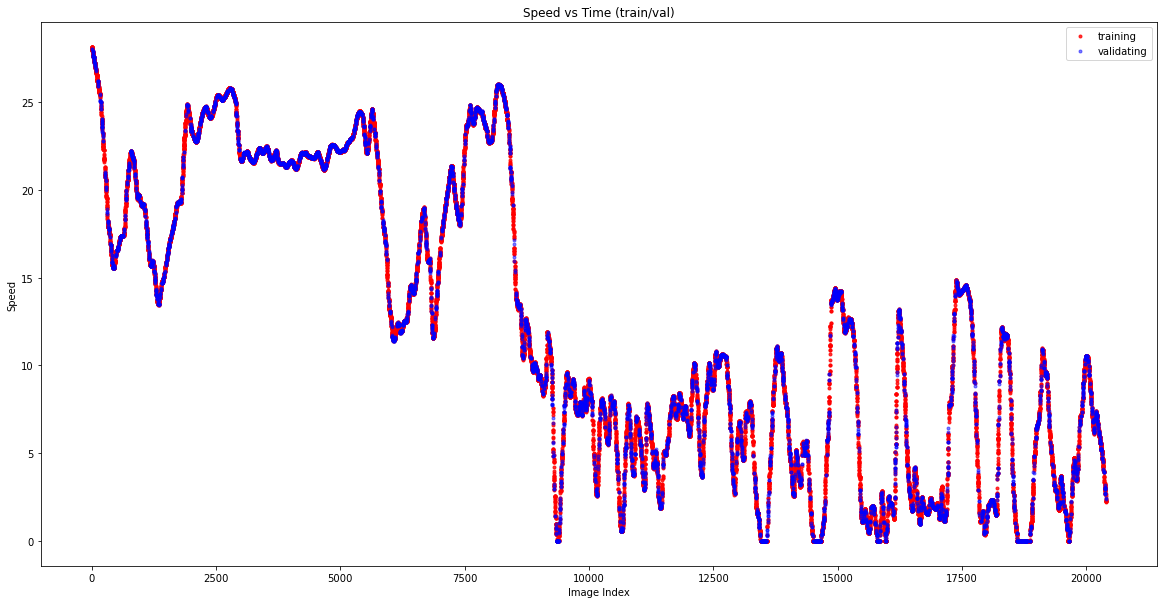

***************

training set shape:  (32596, 4)
validation set shape:  (8202, 4)


In [13]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_df.sort_values("img_index")[["img_index"]], train_df.sort_values("img_index")[["speed"]],"r.",alpha=0.8)
plt.plot(val_df.sort_values("img_index")[["img_index"]], val_df.sort_values("img_index")[["speed"]],"b.", alpha=0.5)
plt.xlabel("Image Index")
plt.ylabel("Speed")
plt.title("Speed vs Time (train/val)")
plt.legend(["training","validating"], loc="upper right")
plt.show()
plt.close()
print("***************\n")
print("training set shape: ",train_df.shape)
print("validation set shape: ",val_df.shape)

In [14]:
def brightness_augmentation(image, factor):
    """
    augements brigtness of the image by multiplying the saturation by a uniform random variable
    return: image with brightness augmentation
    """
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    hsv = np.array(hsv, dtype=np.float64)
    hsv[:,:,2] = hsv[:,:,2] * factor
    rgb = cv2.cvtColor(np.array(hsv,dtype=np.uint8), cv2.COLOR_HSV2RGB)
    return rgb
    
    

original image shape: (480, 640, 3)


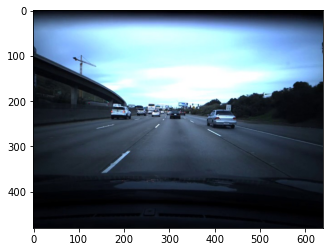

bright_factor: 1.3964657284303335
brightned image


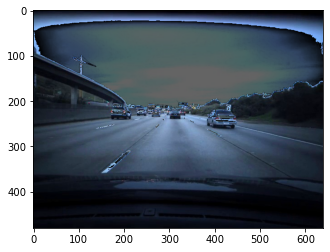

In [15]:
img=mpimg.imread(train_meta['img_path'][60])
print('original image shape:', img.shape)
plt.imshow(img)
plt.show()
plt.close()

bright_factor = 0.7 + np.random.uniform()
print('bright_factor:', bright_factor)
print('brightned image')
img=mpimg.imread(train_meta['img_path'][60])
plt.imshow(brightness_augmentation(img, bright_factor))
plt.show()
plt.close()

In [16]:
def opticalFlowDense(curr_img, next_img):
    """
    input: curr_img, next_img (RGB images)
    
    Calculates optical flow magnitude and angle and place it into HSV image
    
    - Set the saturation to the saturation value of next_img
    - Set the hue to the angles returned from computing the flow params
    - Set the value to the magnitude returned from computing the flow params
    - Convert from HSV to RGB and return RGB image with same size as the original image
    """
    gray_curr = cv2.cvtColor(curr_img, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(next_img, cv2.COLOR_RGB2GRAY)
    
    hsv = np.zeros(shape=(66, 220, 3))
    #set saturation
    hsv[:,:,1] = cv2.cvtColor(next_img, cv2.COLOR_RGB2HSV)[:,:,1]

    # FlowParams
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0
    
    # obtain dense optical flow params
    flow = cv2.calcOpticalFlowFarneback(gray_curr, gray_next,
                                       flow_mat,
                                       image_scale,
                                       nb_images,
                                       win_size,
                                       nb_iterations,
                                       deg_expansion,
                                       STD,
                                       extra)
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[...,0],flow[...,1])
    
    #hue corresponds to direction
    hsv[:,:,0] = ang*(180 / np.pi / 2)
    
    # value corresponds to mag
    hsv[:,:,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    
    # convert hsv to float32
    hsv = np.asarray(hsv, dtype=np.float32)
    rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    return rgb_flow

    

In [17]:
def preprocess_image(image):
    """
    preprocesses the image
    
    input: image (480,640,3) rgb 
    output: image( 220,66,3) rgb
    
    1. crop out black spots
    2. resize to 220,66,3 if not done from perspective transform
    """
    image_cropped = image[35:375, :] #v1 for data
    image = cv2.resize(image_cropped,(220,66), interpolation=cv2.INTER_AREA)
    return image

original image shape: (480, 640, 3)


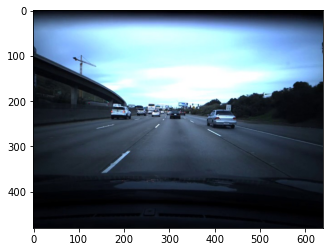

post prosessed image: (66, 220, 3)


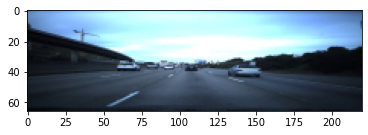

In [18]:
mg=mpimg.imread(train_meta['img_path'][10])
print('original image shape:', img.shape)
plt.imshow(img)
plt.show()
plt.close()

post_img = preprocess_image(img)
print('post prosessed image:', post_img.shape)
plt.imshow(post_img)
plt.show()
plt.close()

In [19]:
def preprocess_img_valid_from_path(img_path,speed):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img, speed
def preprocess_img_from_path(img_path, speed, bright_factor):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = brightness_augmentation(img,bright_factor)
    img = preprocess_image(img)
    return img, speed

In [20]:
def generate_training_data(data,input_size,batch_size = 8):
    image_batch = np.zeros((batch_size, 66,220,3))
    label_batch = np.zeros((batch_size))
    
    while True:
        for i in range(batch_size):
            # get a random index 
            idx = np.random.randint(len(data)-1)
            brighting_factor = 0.2 + np.random.uniform()
            
            row1 = data.iloc[[idx]]
            row2 = data.iloc[[idx + 1]]
            
            # preprocess and get speed data
            x1,y1 = preprocess_img_from_path(row1["img_path"].values[0], row1["speed"].values[0], brighting_factor)
            x2,y2 = preprocess_img_from_path(row2["img_path"].values[0], row2["speed"].values[0], brighting_factor)
            
            # get the flow from two frames
            flow = opticalFlowDense(x1,x2)
            
            # get the avg speed between two frames
            y = np.mean([y1,y2])
            
            image_batch[i] = flow
            label_batch[i] = y
            
        yield skl.utils.shuffle(image_batch, label_batch)

In [21]:
def generate_val_data(data):
    while True:
        for i in range(len(data)-1):
            row1 = data.iloc[[i]]
            row2 = data.iloc[[i+1]]
            
            x1,y1 = preprocess_img_valid_from_path(row1["img_path"].values[0],row1["speed"].values[0])
            x2,y2 = preprocess_img_valid_from_path(row2["img_path"].values[0],row2["speed"].values[0])
            
            flow = opticalFlowDense(x1,x2)
            
            # reshape so that it matches the shape as training
            flow = flow.reshape(1, flow,shape[0], flow.shape[1], flow.shape[2])
            
            y = np.mean([y1,y2])
            
            yield flow, np.array([[y]])
            

In [30]:

def speedchallenge_model1():
    input_shape = (66,220,3)
    model = tf.keras.models.Sequential()
    # normalize each rgb values
    model.add(Lambda(lambda x: x/127.5 -1, input_shape=input_shape))
    
    model.add(Convolution2D(24,(5,5),
                           kernel_initializer=tf.keras.initializers.he_normal(),
                           name="conv2d_1_layer"))
    
    model.add(ELU())    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            kernel_initializer = tf.keras.initializers.he_normal(),
                            name = 'conv2d_2_layer'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = tf.keras.initializers.he_normal(),
                            name = 'conv2d_3_layer'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = tf.keras.initializers.he_normal(),
                            name = 'conv2d_4_layer'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = tf.keras.initializers.he_normal(),
                            name = 'conv2d_5_layer'))
    
    model.add(Flatten(name="flatten"))
    model.add(ELU())
    model.add(Dense(100, kernel_regularizer = tf.keras.initializers.he_normal(), name="fully_connected_1_layer"))
    model.add(ELU())
    model.add(Dense(50, kernel_regularizer = tf.keras.initializers.he_normal(), name="fully_connected_2_layer"))
    model.add(ELU())
    model.add(Dense(10, kernel_regularizer = tf.keras.initializers.he_normal(), name="fully_connected_3_layer"))
    model.add(ELU())
    
    # linear layer
    model.add(Dense(1, kernel_initializer=tf.keras.initializers.he_normal(), name = "ouput_layer"))
    
    # optimizer
    # initial lr = 1e-4
    # learning rate divided into 2 every 100k iteration after the first 300k iteration
    model.compile(optimizer=Adam(learning_rate=1e-4),loss=tf.losses.MeanSquaredError())#["mse"])
    
    return model

In [31]:
# create directory to store model informations
if not os.path.exists(assets_filedir):
    os.makedirs(assets_filedir)

In [32]:
val_generator = generate_val_data(val_df)
val_size = len(val_df)

early_stopping = EarlyStopping(monitor="val_loss",
                             patience=1,
                             verbose=1,
                             min_delta = 0.23,
                             mode="min")
model_chk_pt = ModelCheckpoint(weights_loc,
                              monitor="val_loss",
                              save_best_only=True,
                              mode="min",
                              verbose=1,
                              save_weights_only=True)

tensor_board = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0, write_graph=True, write_images=True)

callbacks_list = [model_chk_pt, tensor_board, early_stopping]

In [33]:
model = speedchallenge_model1()

TypeError: object of type 'ResourceVariable' has no len()

In [ ]:
mpimg.imr